In [1]:
# Cella 0: Import librerie

# Librerie base
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import logging
import pickle
import json
from datetime import datetime

# Modelli ML
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# XGBoost, CatBoost, LightGBM
import xgboost as xgb
import catboost as cb
import lightgbm as lgb

# Validazione e metriche
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Ottimizzazione iperparametri
import optuna
import optunahub
from optuna.pruners import MedianPruner

# ===============================
# CONFIGURAZIONI E PARAMETRI
# ===============================

# Timestamp per questa sessione di training
TRAINING_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

print(f"Timestamp di training: {TRAINING_TIMESTAMP}")

# Directory base da cui leggere i timestamp
DATA_BASE_DIR = Path("data")
# Trova tutti i sottopath con formato timestamp
timestamps = [
    p.name for p in DATA_BASE_DIR.iterdir()
    if p.is_dir() and re.match(r"\d{8}_\d{6}$", p.name)
]
# Prendi il timestamp più recente
PREPROCESSING_TIMESTAMP = max(timestamps)
# Costruisci i path
DATA_DIR = DATA_BASE_DIR / PREPROCESSING_TIMESTAMP
MODELS_DIR = Path("models") / PREPROCESSING_TIMESTAMP
TRANSFORMERS_DIR = Path("transformers")
print(f"Timestamp del preprocessing: {PREPROCESSING_TIMESTAMP}")

# Paths input (dal preprocessing)
TRAIN_PATH = DATA_DIR / "train.csv"
TEST_PATH = DATA_DIR / "test.csv"
PREPROCESSING_REPORT_PATH = DATA_DIR / "preprocessing_report.json"
TRANSFORMERS_PATH = TRANSFORMERS_DIR / f"{PREPROCESSING_TIMESTAMP}.pkl"

# Paths output (training)
TRAINING_MODELS_DIR = Path(f"models/{TRAINING_TIMESTAMP}")
TRAINING_MODELS_DIR.mkdir(parents=True, exist_ok=True)

TRAINING_RESULTS_DIR = Path(f"results/{TRAINING_TIMESTAMP}")
TRAINING_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# File di output
BEST_MODELS_PATH = TRAINING_MODELS_DIR / "best_models.pkl"
ENSEMBLE_MODELS_PATH = TRAINING_MODELS_DIR / "ensemble_models.pkl"
TRAINING_RESULTS_PATH = TRAINING_RESULTS_DIR / "training_results.json"
FEATURE_IMPORTANCE_PATH = TRAINING_RESULTS_DIR / "feature_importance.csv"

# Parametri di training
VAL_SIZE = 0.18  # 18% del train per validation
RANDOM_STATE = 42
N_JOBS = -1

# Parametri Optuna
N_TRIALS = 100
OPTUNA_TIMEOUT = 7200  # 2 ora timeout
CV_FOLDS = 5
OPTUNA_PRUNING_PERCENTILE = 25

# Parametri Cross-Validation
CV_SCORING = 'neg_root_mean_squared_error'

# Configurazioni display
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Setup logging
LOG_DIR = Path(f"log/training/{TRAINING_TIMESTAMP}")
LOG_DIR.mkdir(parents=True, exist_ok=True)
LOG_FILE_PATH = LOG_DIR / f"{TRAINING_TIMESTAMP}.log"

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(LOG_FILE_PATH),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Configurazioni Optuna (riduce verbosity)
optuna.logging.set_verbosity(optuna.logging.WARNING)

logger.info(f"Configurazioni training completate - Timestamp: {TRAINING_TIMESTAMP}")
logger.info(f"Preprocessing utilizzato: {PREPROCESSING_TIMESTAMP}")
logger.info(f"Modelli salvati in: {TRAINING_MODELS_DIR}")
logger.info(f"Risultati salvati in: {TRAINING_RESULTS_DIR}")


/home/tesisti-ing/seai_f03/altro/Strimatrix/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-27 16:36:11,620 - INFO - Configurazioni training completate - Timestamp: 20250627_163611
2025-06-27 16:36:11,621 - INFO - Preprocessing utilizzato: 20250627_155451
2025-06-27 16:36:11,621 - INFO - Modelli salvati in: models/20250627_163611
2025-06-27 16:36:11,622 - INFO - Risultati salvati in: results/20250627_163611


Timestamp di training: 20250627_163611
Timestamp del preprocessing: 20250627_155451


In [2]:
# Cella 1: Caricamento dataset

def load_processed_data():
    """Carica i dataset preprocessati e i trasformatori"""
    logger.info("Caricamento dati preprocessati...")
    
    # Carica dataset
    train_df = pd.read_csv(TRAIN_PATH)
    test_df = pd.read_csv(TEST_PATH)
    
    # Carica trasformatori
    with open(TRANSFORMERS_PATH, 'rb') as f:
        transformers = pickle.load(f)
    
    # Carica report preprocessing
    with open(PREPROCESSING_REPORT_PATH, 'r') as f:
        preprocessing_report = json.load(f)
    
    logger.info(f"Dataset train caricato: {train_df.shape}")
    logger.info(f"Dataset test caricato: {test_df.shape}")
    logger.info(f"Trasformatori caricati: {list(transformers.keys())}")
    
    # Verifica integrità dati
    if train_df.isnull().values.any() or test_df.isnull().values.any():
        logger.error("Dati contengono valori NaN!")
        raise ValueError("Dataset contiene valori NaN")
    
    # Informazioni sui dati
    logger.info(f"Colonne train: {list(train_df.columns)}")
    logger.info(f"Range target_log train: [{train_df['target_log'].min():.3f}, {train_df['target_log'].max():.3f}]")
    logger.info(f"Range target_original train: [{train_df['target_original'].min():.3f}, {train_df['target_original'].max():.3f}]")
    
    return train_df, test_df, transformers, preprocessing_report

# Caricamento dati
train_df, test_df, transformers, preprocessing_report = load_processed_data()


2025-06-27 16:36:11,628 - INFO - Caricamento dati preprocessati...
2025-06-27 16:36:11,697 - INFO - Dataset train caricato: (3597, 44)
2025-06-27 16:36:11,697 - INFO - Dataset test caricato: (642, 44)
2025-06-27 16:36:11,698 - INFO - Trasformatori caricati: ['scaler', 'pca_model', 'outlier_detector', 'encoding_info', 'imputers', 'timestamp']
2025-06-27 16:36:11,698 - INFO - Colonne train: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35', 'PC36', 'PC37', 'PC38', 'PC39', 'PC40', 'PC41', 'PC42', 'target_log', 'target_original']
2025-06-27 16:36:11,699 - INFO - Range target_log train: [7.245, 13.911]
2025-06-27 16:36:11,699 - INFO - Range target_original train: [1400.000, 1100000.000]


In [3]:
# Cella 2: Split del train in train e validation (18% per validation)

def split_train_validation(train_df, val_size=VAL_SIZE, random_state=RANDOM_STATE):
    """Divide il training set in train e validation"""
    logger.info(f"Split train/validation (val_size={val_size})...")
    
    # Separa features e target
    feature_cols = [col for col in train_df.columns if col.startswith('PC')]
    X = train_df[feature_cols]
    y_log = train_df['target_log']
    y_original = train_df['target_original']
    
    # Split
    X_train, X_val, y_train_log, y_val_log, y_train_orig, y_val_orig = train_test_split(
        X, y_log, y_original, 
        test_size=val_size, 
        random_state=random_state
    )
    
    logger.info(f"Train set: {X_train.shape[0]} samples")
    logger.info(f"Validation set: {X_val.shape[0]} samples")
    logger.info(f"Feature columns: {len(feature_cols)} (PC1 to PC{len(feature_cols)})")
    
    # Statistiche sui target
    logger.info(f"Target log - Train: μ={y_train_log.mean():.3f}, σ={y_train_log.std():.3f}")
    logger.info(f"Target log - Val: μ={y_val_log.mean():.3f}, σ={y_val_log.std():.3f}")
    
    return X_train, X_val, y_train_log, y_val_log, y_train_orig, y_val_orig, feature_cols

X_train, X_val, y_train_log, y_val_log, y_train_orig, y_val_orig, feature_cols = split_train_validation(train_df)

# Preparazione test set
X_test = test_df[feature_cols]
y_test_log = test_df['target_log']
y_test_orig = test_df['target_original']


2025-06-27 16:36:11,706 - INFO - Split train/validation (val_size=0.18)...
2025-06-27 16:36:11,709 - INFO - Train set: 2949 samples
2025-06-27 16:36:11,709 - INFO - Validation set: 648 samples
2025-06-27 16:36:11,709 - INFO - Feature columns: 42 (PC1 to PC42)
2025-06-27 16:36:11,710 - INFO - Target log - Train: μ=10.614, σ=1.053
2025-06-27 16:36:11,710 - INFO - Target log - Val: μ=10.661, σ=1.064


In [4]:
# Cella 3: Definizione funzioni obiettivo Optuna

def objective_random_forest(trial):
    """Funzione obiettivo per Random Forest"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': RANDOM_STATE,
        'n_jobs': N_JOBS
    }
    
    model = RandomForestRegressor(**params)
    
    # Cross-validation
    kfold = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X_train, y_train_log, cv=kfold, scoring=CV_SCORING, n_jobs=N_JOBS)
    
    return -scores.mean()  # Optuna minimizza, ma vogliamo massimizzare il punteggio

def objective_gradient_boosting(trial):
    """Funzione obiettivo per Gradient Boosting"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': RANDOM_STATE
    }
    
    model = GradientBoostingRegressor(**params)
    
    kfold = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X_train, y_train_log, cv=kfold, scoring=CV_SCORING, n_jobs=N_JOBS)
    
    return -scores.mean()

def objective_xgboost(trial):
    """Funzione obiettivo per XGBoost"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': RANDOM_STATE,
        'n_jobs': N_JOBS,
        'verbosity': 0
    }
    
    model = xgb.XGBRegressor(**params)
    
    kfold = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X_train, y_train_log, cv=kfold, scoring=CV_SCORING, n_jobs=N_JOBS)
    
    return -scores.mean()

def objective_catboost(trial):
    """Funzione obiettivo per CatBoost"""
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'random_seed': RANDOM_STATE,
        'verbose': False,
        'thread_count': N_JOBS if N_JOBS > 0 else None
    }
    
    # Parametri aggiuntivi per bootstrap_type
    if params['bootstrap_type'] == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif params['bootstrap_type'] == 'Bernoulli':
        params['subsample'] = trial.suggest_float('subsample', 0.6, 1.0)
    
    model = cb.CatBoostRegressor(**params)
    
    kfold = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X_train, y_train_log, cv=kfold, scoring=CV_SCORING, n_jobs=N_JOBS)
    
    return -scores.mean()

def objective_lightgbm(trial):
    """Funzione obiettivo per LightGBM"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 1e1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': RANDOM_STATE,
        'n_jobs': N_JOBS,
        'verbose': -1
    }
    
    model = lgb.LGBMRegressor(**params)
    
    kfold = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X_train, y_train_log, cv=kfold, scoring=CV_SCORING, n_jobs=N_JOBS)
    
    return -scores.mean()

def objective_hist_gradient_boosting(trial):
    """Funzione obiettivo per Histogram-based Gradient Boosting"""
    params = {
        'max_iter': trial.suggest_int('max_iter', 100, 1000, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 50),
        'l2_regularization': trial.suggest_float('l2_regularization', 0, 10),
        'max_bins': trial.suggest_int('max_bins', 32, 255),
        'random_state': RANDOM_STATE
    }
    
    model = HistGradientBoostingRegressor(**params)
    
    kfold = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X_train, y_train_log, cv=kfold, scoring=CV_SCORING, n_jobs=N_JOBS)
    
    return -scores.mean()

logger.info("Funzioni obiettivo Optuna definite per 6 algoritmi")


2025-06-27 16:36:11,723 - INFO - Funzioni obiettivo Optuna definite per 6 algoritmi


In [5]:
# Cella 4: Ottimizzazione estesa con Optuna

def optimize_model(objective_func, model_name, n_trials=N_TRIALS, timeout=OPTUNA_TIMEOUT):
    """Ottimizza un modello usando Optuna"""
    logger.info(f"Ottimizzazione {model_name}...")
    
    # Configurazione studio Optuna
    module = optunahub.load_module(package="samplers/auto_sampler")
    pruner = MedianPruner(n_startup_trials=10, n_warmup_steps=5, interval_steps=1)
    
    study = optuna.create_study(
        direction='minimize',
        sampler=module.AutoSampler(),
        pruner=pruner,
        study_name=f"{model_name}_optimization"
    )
    
    # Ottimizzazione
    start_time = datetime.now()
    study.optimize(objective_func, n_trials=n_trials, timeout=timeout, show_progress_bar=True)
    end_time = datetime.now()
    
    optimization_time = (end_time - start_time).total_seconds()
    
    logger.info(f"{model_name} - Migliori parametri: {study.best_params}")
    logger.info(f"{model_name} - Miglior punteggio: {study.best_value:.6f}")
    logger.info(f"{model_name} - Trials completati: {len(study.trials)}")
    logger.info(f"{model_name} - Tempo ottimizzazione: {optimization_time:.2f} secondi")
    
    return study.best_params, study.best_value, study

def run_full_optimization():
    """Esegue l'ottimizzazione completa per tutti i modelli"""
    logger.info("=" * 50)
    logger.info("INIZIO OTTIMIZZAZIONE COMPLETA")
    logger.info("=" * 50)
    
    optimization_results = {}
    
    # Definizione modelli da ottimizzare
    models_to_optimize = [
        (objective_random_forest, "RandomForest"),
        (objective_gradient_boosting, "GradientBoosting"),
        (objective_xgboost, "XGBoost"),
        (objective_catboost, "CatBoost"),
        (objective_lightgbm, "LightGBM"),
        (objective_hist_gradient_boosting, "HistGradientBoosting")
    ]
    
    total_start_time = datetime.now()
    
    for objective_func, model_name in models_to_optimize:
        try:
            best_params, best_score, study = optimize_model(objective_func, model_name)
            optimization_results[model_name] = {
                'best_params': best_params,
                'best_score': best_score,
                'study': study,
                'n_trials': len(study.trials)
            }
            logger.info(f"✓ {model_name} ottimizzato con successo")
        except Exception as e:
            logger.error(f"✗ Errore nell'ottimizzazione di {model_name}: {str(e)}")
            optimization_results[model_name] = {
                'error': str(e),
                'best_params': None,
                'best_score': None
            }
    
    total_end_time = datetime.now()
    total_time = (total_end_time - total_start_time).total_seconds()
    
    logger.info("=" * 50)
    logger.info("RIEPILOGO OTTIMIZZAZIONE")
    logger.info("=" * 50)
    logger.info(f"Tempo totale: {total_time:.2f} secondi ({total_time/60:.2f} minuti)")
    
    # Classifica modelli per performance
    successful_models = {k: v for k, v in optimization_results.items() if v.get('best_score') is not None}
    if successful_models:
        sorted_models = sorted(successful_models.items(), key=lambda x: x[1]['best_score'])
        logger.info("\nClassifica modelli (migliore al peggiore):")
        for i, (model_name, results) in enumerate(sorted_models, 1):
            logger.info(f"{i}. {model_name}: {results['best_score']:.6f}")
    
    return optimization_results

# Esecuzione ottimizzazione
optimization_results = run_full_optimization()


2025-06-27 16:36:11,731 - INFO - ==================================================
2025-06-27 16:36:11,732 - INFO - INIZIO OTTIMIZZAZIONE COMPLETA
2025-06-27 16:36:11,732 - INFO - ==================================================
2025-06-27 16:36:11,732 - INFO - Ottimizzazione RandomForest...
Best trial: 98. Best value: 0.550251: 100%|██████████| 100/100 [03:09<00:00,  1.89s/it, 189.20/7200 seconds]
2025-06-27 16:39:21,750 - INFO - RandomForest - Migliori parametri: {'n_estimators': 1000, 'max_depth': 41, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}
2025-06-27 16:39:21,750 - INFO - RandomForest - Miglior punteggio: 0.550251
2025-06-27 16:39:21,756 - INFO - RandomForest - Trials completati: 100
2025-06-27 16:39:21,756 - INFO - RandomForest - Tempo ottimizzazione: 189.20 secondi
2025-06-27 16:39:21,761 - INFO - ✓ RandomForest ottimizzato con successo
2025-06-27 16:39:21,762 - INFO - Ottimizzazione GradientBoosting...
Best trial: 22. Best va

In [6]:
# Cella 5: Modelli baseline estesi per confronto

def create_baseline_models():
    """Crea modelli baseline per confronto"""
    logger.info("Creazione modelli baseline...")
    
    baseline_models = {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(random_state=RANDOM_STATE),
        'Lasso': Lasso(random_state=RANDOM_STATE),
        'ElasticNet': ElasticNet(random_state=RANDOM_STATE),
        'DecisionTree': DecisionTreeRegressor(random_state=RANDOM_STATE),
        'KNN': KNeighborsRegressor(),
        'SVR': SVR()
    }
    
    baseline_results = {}
    
    logger.info("Valutazione modelli baseline con cross-validation...")
    
    for name, model in baseline_models.items():
        try:
            kfold = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
            scores = cross_val_score(model, X_train, y_train_log, cv=kfold, scoring=CV_SCORING, n_jobs=N_JOBS)
            
            baseline_results[name] = {
                'cv_score_mean': -scores.mean(),
                'cv_score_std': scores.std(),
                'model': model
            }
            
            logger.info(f"{name}: {-scores.mean():.6f} ± {scores.std():.6f}")
            
        except Exception as e:
            logger.error(f"Errore con {name}: {str(e)}")
            baseline_results[name] = {'error': str(e)}
    
    return baseline_results

# Creazione baseline
baseline_results = create_baseline_models()


2025-06-27 18:48:18,027 - INFO - Creazione modelli baseline...
2025-06-27 18:48:18,027 - INFO - Valutazione modelli baseline con cross-validation...
2025-06-27 18:48:18,040 - INFO - LinearRegression: 0.680318 ± 0.041374
2025-06-27 18:48:18,053 - INFO - Ridge: 0.680292 ± 0.041346
2025-06-27 18:48:18,065 - INFO - Lasso: 1.052892 ± 0.021608
2025-06-27 18:48:18,077 - INFO - ElasticNet: 0.927044 ± 0.023148
2025-06-27 18:48:18,191 - INFO - DecisionTree: 0.802908 ± 0.045215
2025-06-27 18:48:18,224 - INFO - KNN: 0.715443 ± 0.018484
2025-06-27 18:48:18,377 - INFO - SVR: 0.521259 ± 0.010671


In [7]:
# Cella 6: Creazione ensemble models (Voting e Stacking)

def create_optimized_models(optimization_results):
    """Crea modelli ottimizzati dai risultati Optuna"""
    logger.info("Creazione modelli ottimizzati...")
    
    optimized_models = {}
    
    for model_name, results in optimization_results.items():
        if results.get('best_params') is not None:
            try:
                if model_name == "RandomForest":
                    model = RandomForestRegressor(**results['best_params'])
                elif model_name == "GradientBoosting":
                    model = GradientBoostingRegressor(**results['best_params'])
                elif model_name == "XGBoost":
                    model = xgb.XGBRegressor(**results['best_params'])
                elif model_name == "CatBoost":
                    model = cb.CatBoostRegressor(**results['best_params'])
                elif model_name == "LightGBM":
                    model = lgb.LGBMRegressor(**results['best_params'])
                elif model_name == "HistGradientBoosting":
                    model = HistGradientBoostingRegressor(**results['best_params'])
                
                optimized_models[model_name] = model
                logger.info(f"✓ {model_name} ottimizzato creato")
                
            except Exception as e:
                logger.error(f"✗ Errore nella creazione di {model_name}: {str(e)}")
    
    return optimized_models

def create_ensemble_models(optimized_models):
    """Crea modelli ensemble (Voting e Stacking)"""
    logger.info("Creazione modelli ensemble...")
    
    if len(optimized_models) < 2:
        logger.warning("Meno di 2 modelli ottimizzati disponibili per ensemble")
        return {}
    
    ensemble_models = {}
    
    # Seleziona i migliori 5 modelli per ensemble
    successful_models = {k: v for k, v in optimization_results.items() if v.get('best_score') is not None}
    best_models = sorted(successful_models.items(), key=lambda x: x[1]['best_score'])[:5]
    
    ensemble_estimators = []
    for model_name, _ in best_models:
        if model_name in optimized_models:
            ensemble_estimators.append((model_name, optimized_models[model_name]))
    
    if len(ensemble_estimators) >= 2:
        # Voting Regressor
        try:
            voting_regressor = VotingRegressor(
                estimators=ensemble_estimators,
                n_jobs=N_JOBS
            )
            ensemble_models['VotingRegressor'] = voting_regressor
            logger.info(f"✓ VotingRegressor creato con {len(ensemble_estimators)} modelli")
        except Exception as e:
            logger.error(f"✗ Errore nella creazione VotingRegressor: {str(e)}")
        
        # Stacking Regressor
        try:
            stacking_regressor = StackingRegressor(
                estimators=ensemble_estimators,
                final_estimator=Ridge(random_state=RANDOM_STATE),
                cv=5,
                n_jobs=N_JOBS
            )
            ensemble_models['StackingRegressor'] = stacking_regressor
            logger.info(f"✓ StackingRegressor creato con {len(ensemble_estimators)} modelli")
        except Exception as e:
            logger.error(f"✗ Errore nella creazione StackingRegressor: {str(e)}")
    
    return ensemble_models

# Creazione modelli ottimizzati e ensemble
optimized_models = create_optimized_models(optimization_results)
ensemble_models = create_ensemble_models(optimized_models)


2025-06-27 18:48:18,386 - INFO - Creazione modelli ottimizzati...
2025-06-27 18:48:18,387 - INFO - ✓ RandomForest ottimizzato creato
2025-06-27 18:48:18,387 - INFO - ✓ GradientBoosting ottimizzato creato
2025-06-27 18:48:18,388 - INFO - ✓ XGBoost ottimizzato creato
2025-06-27 18:48:18,388 - INFO - ✓ CatBoost ottimizzato creato
2025-06-27 18:48:18,388 - INFO - ✓ LightGBM ottimizzato creato
2025-06-27 18:48:18,388 - INFO - ✓ HistGradientBoosting ottimizzato creato
2025-06-27 18:48:18,389 - INFO - Creazione modelli ensemble...
2025-06-27 18:48:18,389 - INFO - ✓ VotingRegressor creato con 5 modelli
2025-06-27 18:48:18,389 - INFO - ✓ StackingRegressor creato con 5 modelli


In [8]:
# Cella 7: Training e valutazione su validation set

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """Valuta un singolo modello sul validation set"""
    try:
        # Training
        start_time = datetime.now()
        model.fit(X_train, y_train)
        training_time = (datetime.now() - start_time).total_seconds()
        
        # Predizioni
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        
        # Metriche
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        train_r2 = r2_score(y_train, y_pred_train)
        val_r2 = r2_score(y_val, y_pred_val)
        train_mae = mean_absolute_error(y_train, y_pred_train)
        val_mae = mean_absolute_error(y_val, y_pred_val)
        
        # MAPE (evita divisione per zero)
        train_mape = mean_absolute_percentage_error(y_train, y_pred_train) * 100
        val_mape = mean_absolute_percentage_error(y_val, y_pred_val) * 100
        
        results = {
            'model_name': model_name,
            'model': model,
            'training_time': training_time,
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            'train_r2': train_r2,
            'val_r2': val_r2,
            'train_mae': train_mae,
            'val_mae': val_mae,
            'train_mape': train_mape,
            'val_mape': val_mape,
            'overfit_ratio': val_rmse / train_rmse if train_rmse > 0 else float('inf'),
            'predictions_train': y_pred_train,
            'predictions_val': y_pred_val
        }
        
        logger.info(f"✓ {model_name} - Val RMSE: {val_rmse:.6f}, Val R²: {val_r2:.4f}")
        return results
        
    except Exception as e:
        logger.error(f"✗ Errore nella valutazione di {model_name}: {str(e)}")
        return {
            'model_name': model_name,
            'error': str(e),
            'model': None
        }

def evaluate_all_models():
    """Valuta tutti i modelli (baseline, ottimizzati, ensemble)"""
    logger.info("=" * 60)
    logger.info("TRAINING E VALUTAZIONE SU VALIDATION SET")
    logger.info("=" * 60)
    
    all_results = {}
    
    # 1. Modelli baseline
    logger.info("Valutazione modelli baseline...")
    for name, baseline_data in baseline_results.items():
        if 'model' in baseline_data:
            results = evaluate_model(
                baseline_data['model'], X_train, y_train_log, X_val, y_val_log, f"Baseline_{name}"
            )
            all_results[f"Baseline_{name}"] = results
    
    # 2. Modelli ottimizzati
    logger.info("Valutazione modelli ottimizzati...")
    for name, model in optimized_models.items():
        results = evaluate_model(model, X_train, y_train_log, X_val, y_val_log, f"Optimized_{name}")
        all_results[f"Optimized_{name}"] = results
    
    # 3. Modelli ensemble
    logger.info("Valutazione modelli ensemble...")
    for name, model in ensemble_models.items():
        results = evaluate_model(model, X_train, y_train_log, X_val, y_val_log, f"Ensemble_{name}")
        all_results[f"Ensemble_{name}"] = results
    
    return all_results

# Esecuzione valutazione
validation_results = evaluate_all_models()

2025-06-27 18:48:18,396 - INFO - ============================================================
2025-06-27 18:48:18,397 - INFO - TRAINING E VALUTAZIONE SU VALIDATION SET
2025-06-27 18:48:18,397 - INFO - ============================================================
2025-06-27 18:48:18,397 - INFO - Valutazione modelli baseline...
2025-06-27 18:48:18,404 - INFO - ✓ Baseline_LinearRegression - Val RMSE: 0.701983, Val R²: 0.5641
2025-06-27 18:48:18,408 - INFO - ✓ Baseline_Ridge - Val RMSE: 0.701951, Val R²: 0.5642
2025-06-27 18:48:18,413 - INFO - ✓ Baseline_Lasso - Val RMSE: 1.064318, Val R²: -0.0020
2025-06-27 18:48:18,417 - INFO - ✓ Baseline_ElasticNet - Val RMSE: 0.920777, Val R²: 0.2501
2025-06-27 18:48:18,538 - INFO - ✓ Baseline_DecisionTree - Val RMSE: 0.758946, Val R²: 0.4905
2025-06-27 18:48:18,609 - INFO - ✓ Baseline_KNN - Val RMSE: 0.713548, Val R²: 0.5496
2025-06-27 18:48:19,016 - INFO - ✓ Baseline_SVR - Val RMSE: 0.541431, Val R²: 0.7407
2025-06-27 18:48:19,016 - INFO - Valutazione

0:	learn: 1.0320316	total: 48.2ms	remaining: 43.4s
1:	learn: 1.0104223	total: 49.2ms	remaining: 22.1s
2:	learn: 0.9887900	total: 49.8ms	remaining: 14.9s
3:	learn: 0.9712777	total: 50.5ms	remaining: 11.3s
4:	learn: 0.9552170	total: 51.1ms	remaining: 9.15s
5:	learn: 0.9411965	total: 51.8ms	remaining: 7.71s
6:	learn: 0.9243765	total: 52.4ms	remaining: 6.69s
7:	learn: 0.9101124	total: 53.1ms	remaining: 5.92s
8:	learn: 0.8955983	total: 53.7ms	remaining: 5.32s
9:	learn: 0.8812303	total: 54.3ms	remaining: 4.83s
10:	learn: 0.8676658	total: 55ms	remaining: 4.44s
11:	learn: 0.8544870	total: 56.8ms	remaining: 4.2s
12:	learn: 0.8436358	total: 57.5ms	remaining: 3.92s
13:	learn: 0.8327730	total: 58.2ms	remaining: 3.68s
14:	learn: 0.8215474	total: 58.8ms	remaining: 3.47s
15:	learn: 0.8111820	total: 59.4ms	remaining: 3.28s
16:	learn: 0.8019833	total: 60.1ms	remaining: 3.12s
17:	learn: 0.7938362	total: 60.7ms	remaining: 2.98s
18:	learn: 0.7841458	total: 61.4ms	remaining: 2.85s
19:	learn: 0.7756703	tota

2025-06-27 18:49:15,272 - INFO - ✓ Optimized_CatBoost - Val RMSE: 0.502697, Val R²: 0.7765


797:	learn: 0.2249502	total: 575ms	remaining: 73.5ms
798:	learn: 0.2246559	total: 576ms	remaining: 72.8ms
799:	learn: 0.2244436	total: 576ms	remaining: 72ms
800:	learn: 0.2242541	total: 577ms	remaining: 71.3ms
801:	learn: 0.2240988	total: 577ms	remaining: 70.6ms
802:	learn: 0.2238485	total: 578ms	remaining: 69.8ms
803:	learn: 0.2237269	total: 579ms	remaining: 69.1ms
804:	learn: 0.2235221	total: 579ms	remaining: 68.4ms
805:	learn: 0.2233827	total: 580ms	remaining: 67.6ms
806:	learn: 0.2231024	total: 581ms	remaining: 66.9ms
807:	learn: 0.2228943	total: 581ms	remaining: 66.2ms
808:	learn: 0.2227046	total: 582ms	remaining: 65.5ms
809:	learn: 0.2224922	total: 583ms	remaining: 64.7ms
810:	learn: 0.2221792	total: 583ms	remaining: 64ms
811:	learn: 0.2218723	total: 584ms	remaining: 63.3ms
812:	learn: 0.2216516	total: 584ms	remaining: 62.5ms
813:	learn: 0.2213406	total: 585ms	remaining: 61.8ms
814:	learn: 0.2212988	total: 586ms	remaining: 61.1ms
815:	learn: 0.2211618	total: 586ms	remaining: 60.4

2025-06-27 18:49:38,401 - INFO - ✓ Optimized_LightGBM - Val RMSE: 0.504783, Val R²: 0.7746
2025-06-27 18:50:59,387 - INFO - ✓ Optimized_HistGradientBoosting - Val RMSE: 0.507166, Val R²: 0.7725
2025-06-27 18:50:59,388 - INFO - Valutazione modelli ensemble...


0:	learn: 1.0320316	total: 48.6ms	remaining: 43.7s
1:	learn: 1.0104223	total: 49.3ms	remaining: 22.1s
2:	learn: 0.9887900	total: 50ms	remaining: 15s
3:	learn: 0.9712777	total: 50.7ms	remaining: 11.4s
4:	learn: 0.9552170	total: 51.4ms	remaining: 9.21s
5:	learn: 0.9411965	total: 52.1ms	remaining: 7.77s
6:	learn: 0.9243765	total: 52.8ms	remaining: 6.74s
7:	learn: 0.9101124	total: 53.5ms	remaining: 5.96s
8:	learn: 0.8955983	total: 54.1ms	remaining: 5.36s
9:	learn: 0.8812303	total: 55.4ms	remaining: 4.93s
10:	learn: 0.8676658	total: 56.7ms	remaining: 4.58s
11:	learn: 0.8544870	total: 57.4ms	remaining: 4.25s
12:	learn: 0.8436358	total: 58.1ms	remaining: 3.96s
13:	learn: 0.8327730	total: 58.8ms	remaining: 3.72s
14:	learn: 0.8215474	total: 59.5ms	remaining: 3.51s
15:	learn: 0.8111820	total: 60.1ms	remaining: 3.32s
16:	learn: 0.8019833	total: 60.8ms	remaining: 3.16s
17:	learn: 0.7938362	total: 61.5ms	remaining: 3.01s
18:	learn: 0.7841458	total: 62.2ms	remaining: 2.88s
19:	learn: 0.7756703	total

2025-06-27 18:51:32,937 - INFO - ✓ Ensemble_VotingRegressor - Val RMSE: 0.496419, Val R²: 0.7820


0:	learn: 1.0320316	total: 48.3ms	remaining: 43.5s
1:	learn: 1.0104223	total: 49.1ms	remaining: 22s
2:	learn: 0.9887900	total: 49.8ms	remaining: 14.9s
3:	learn: 0.9712777	total: 50.4ms	remaining: 11.3s
4:	learn: 0.9552170	total: 51.1ms	remaining: 9.15s
5:	learn: 0.9411965	total: 51.8ms	remaining: 7.72s
6:	learn: 0.9243765	total: 52.5ms	remaining: 6.69s
7:	learn: 0.9101124	total: 53.1ms	remaining: 5.92s
8:	learn: 0.8955983	total: 56.7ms	remaining: 5.61s
9:	learn: 0.8812303	total: 57.3ms	remaining: 5.1s
10:	learn: 0.8676658	total: 59.1ms	remaining: 4.78s
11:	learn: 0.8544870	total: 59.8ms	remaining: 4.42s
12:	learn: 0.8436358	total: 60.4ms	remaining: 4.12s
13:	learn: 0.8327730	total: 61.1ms	remaining: 3.87s
14:	learn: 0.8215474	total: 61.8ms	remaining: 3.64s
15:	learn: 0.8111820	total: 62.4ms	remaining: 3.45s
16:	learn: 0.8019833	total: 63.1ms	remaining: 3.27s
17:	learn: 0.7938362	total: 63.9ms	remaining: 3.13s
18:	learn: 0.7841458	total: 64.5ms	remaining: 2.99s
19:	learn: 0.7756703	tota

2025-06-27 18:52:27,992 - INFO - ✓ Ensemble_StackingRegressor - Val RMSE: 0.496824, Val R²: 0.7817


In [9]:
# Cella 8: Analisi risultati e selezione migliori modelli

def analyze_validation_results(validation_results):
    """Analizza i risultati della validazione"""
    logger.info("=" * 60)
    logger.info("ANALISI RISULTATI VALIDAZIONE")
    logger.info("=" * 60)
    
    # Filtra modelli con errori
    valid_results = {k: v for k, v in validation_results.items() if 'error' not in v}
    
    if not valid_results:
        logger.error("Nessun modello valutato con successo!")
        return pd.DataFrame(), {}
    
    # Crea DataFrame per analisi
    results_data = []
    for model_name, results in valid_results.items():
        results_data.append({
            'Model': model_name,
            'Train_RMSE': results['train_rmse'],
            'Val_RMSE': results['val_rmse'],
            'Train_R2': results['train_r2'],
            'Val_R2': results['val_r2'],
            'Train_MAE': results['train_mae'],
            'Val_MAE': results['val_mae'],
            'Train_MAPE': results['train_mape'],
            'Val_MAPE': results['val_mape'],
            'Overfit_Ratio': results['overfit_ratio'],
            'Training_Time': results['training_time']
        })
    
    df_results = pd.DataFrame(results_data)
    
    # Ordina per Val_RMSE (migliore = più basso)
    df_results = df_results.sort_values('Val_RMSE').reset_index(drop=True)
    
    logger.info("Top 10 modelli per Val_RMSE:")
    print("\n" + "="*100)
    print(f"{'Rank':<4} {'Model':<30} {'Val_RMSE':<10} {'Val_R²':<8} {'Val_MAE':<9} {'Overfit':<7} {'Time(s)':<8}")
    print("="*100)
    
    for i, row in df_results.head(10).iterrows():
        print(f"{i+1:<4} {row['Model']:<30} {row['Val_RMSE']:<10.6f} {row['Val_R2']:<8.4f} "
              f"{row['Val_MAE']:<9.6f} {row['Overfit_Ratio']:<7.3f} {row['Training_Time']:<8.2f}")
    
    # Selezione migliori modelli per categoria
    best_models = {}
    
    # Miglior modello overall
    best_overall = df_results.iloc[0]['Model']
    best_models['best_overall'] = {
        'name': best_overall,
        'model': valid_results[best_overall]['model'],
        'results': valid_results[best_overall]
    }
    
    # Migliori per categoria
    categories = ['Baseline', 'Optimized', 'Ensemble']
    for category in categories:
        category_models = df_results[df_results['Model'].str.contains(category)]
        if not category_models.empty:
            best_in_category = category_models.iloc[0]['Model']
            best_models[f'best_{category.lower()}'] = {
                'name': best_in_category,
                'model': valid_results[best_in_category]['model'],
                'results': valid_results[best_in_category]
            }
    
    # Modelli con miglior bilancio performance/overfitting
    df_balanced = df_results[df_results['Overfit_Ratio'] <= 1.2]  # Max 20% overfitting
    if not df_balanced.empty:
        best_balanced = df_balanced.iloc[0]['Model']
        best_models['best_balanced'] = {
            'name': best_balanced,
            'model': valid_results[best_balanced]['model'],
            'results': valid_results[best_balanced]
        }
    
    logger.info(f"\nModelli selezionati: {list(best_models.keys())}")
    
    return df_results, best_models

# Analisi risultati
df_validation_results, best_models = analyze_validation_results(validation_results)

2025-06-27 18:52:28,001 - INFO - ============================================================
2025-06-27 18:52:28,002 - INFO - ANALISI RISULTATI VALIDAZIONE
2025-06-27 18:52:28,002 - INFO - ============================================================
2025-06-27 18:52:28,004 - INFO - Top 10 modelli per Val_RMSE:
2025-06-27 18:52:28,006 - INFO - 
Modelli selezionati: ['best_overall', 'best_baseline', 'best_optimized', 'best_ensemble', 'best_balanced']



Rank Model                          Val_RMSE   Val_R²   Val_MAE   Overfit Time(s) 
1    Ensemble_VotingRegressor       0.496419   0.7820   0.349757  3.476   32.56   
2    Ensemble_StackingRegressor     0.496824   0.7817   0.349598  3.087   53.97   
3    Optimized_XGBoost              0.498648   0.7801   0.353318  4.271   10.38   
4    Optimized_CatBoost             0.502697   0.7765   0.353886  2.438   0.75    
5    Optimized_LightGBM             0.504783   0.7746   0.357184  3.252   23.12   
6    Optimized_HistGradientBoosting 0.507166   0.7725   0.358733  4.988   80.09   
7    Optimized_GradientBoosting     0.513966   0.7663   0.365801  3.137   25.53   
8    Baseline_SVR                   0.541431   0.7407   0.366030  1.264   0.17    
9    Optimized_RandomForest         0.545740   0.7366   0.392661  28.825  19.04   
10   Baseline_Ridge                 0.701951   0.5642   0.491618  1.074   0.00    


In [10]:
# Cella 9: Feature Importance Analysis

def calculate_feature_importance(best_models, feature_cols):
    """Calcola feature importance per i migliori modelli"""
    logger.info("=" * 60)
    logger.info("ANALISI FEATURE IMPORTANCE")
    logger.info("=" * 60)
    
    feature_importance_data = []
    feature_importance_summary = pd.DataFrame(index=feature_cols)
    
    for model_key, model_data in best_models.items():
        model_name = model_data['name']
        model = model_data['model']
        
        try:
            # Diversi metodi per ottenere feature importance
            importance = None
            method = "unknown"
            
            if hasattr(model, 'feature_importances_'):
                importance = model.feature_importances_
                method = "feature_importances_"
            elif hasattr(model, 'coef_'):
                importance = np.abs(model.coef_)
                method = "abs(coef_)"
            
            if importance is not None:
                # Normalizza importanze
                importance_norm = importance / importance.sum()
                
                # Aggiungi ai dati
                for i, (feature, imp) in enumerate(zip(feature_cols, importance_norm)):
                    feature_importance_data.append({
                        'Model': model_name,
                        'Feature': feature,
                        'Importance': imp,
                        'Rank': i + 1,
                        'Method': method
                    })
                
                # Aggiungi al summary
                feature_importance_summary[model_name] = importance_norm
                
                logger.info(f"✓ Feature importance calcolata per {model_name} ({method})")
                
                # Top 10 features per questo modello
                top_features = sorted(zip(feature_cols, importance_norm), key=lambda x: x[1], reverse=True)[:10]
                logger.info(f"Top 10 features per {model_name}:")
                for i, (feature, imp) in enumerate(top_features, 1):
                    logger.info(f"  {i:2d}. {feature}: {imp:.4f}")
                
        except Exception as e:
            logger.error(f"✗ Errore calcolo feature importance per {model_name}: {str(e)}")
    
    # Crea DataFrame completo
    df_feature_importance = pd.DataFrame(feature_importance_data)
    
    # Calcola importanza media attraverso tutti i modelli
    if not df_feature_importance.empty:
        avg_importance = df_feature_importance.groupby('Feature')['Importance'].mean().sort_values(ascending=False)
        feature_importance_summary['Average'] = avg_importance
        
        logger.info("\nTop 15 features (media tra tutti i modelli):")
        for i, (feature, imp) in enumerate(avg_importance.head(15).items(), 1):
            logger.info(f"  {i:2d}. {feature}: {imp:.4f}")
    
    return df_feature_importance, feature_importance_summary

# Calcolo feature importance
df_feature_importance, feature_importance_summary = calculate_feature_importance(best_models, feature_cols)

2025-06-27 18:52:28,014 - INFO - ============================================================
2025-06-27 18:52:28,015 - INFO - ANALISI FEATURE IMPORTANCE
2025-06-27 18:52:28,015 - INFO - ============================================================
2025-06-27 18:52:28,018 - INFO - ✓ Feature importance calcolata per Optimized_XGBoost (feature_importances_)
2025-06-27 18:52:28,018 - INFO - Top 10 features per Optimized_XGBoost:
2025-06-27 18:52:28,018 - INFO -    1. PC5: 0.1946
2025-06-27 18:52:28,018 - INFO -    2. PC6: 0.0842
2025-06-27 18:52:28,019 - INFO -    3. PC3: 0.0687
2025-06-27 18:52:28,019 - INFO -    4. PC9: 0.0564
2025-06-27 18:52:28,019 - INFO -    5. PC4: 0.0557
2025-06-27 18:52:28,019 - INFO -    6. PC11: 0.0376
2025-06-27 18:52:28,019 - INFO -    7. PC12: 0.0327
2025-06-27 18:52:28,020 - INFO -    8. PC2: 0.0299
2025-06-27 18:52:28,020 - INFO -    9. PC21: 0.0289
2025-06-27 18:52:28,020 - INFO -   10. PC1: 0.0261
2025-06-27 18:52:28,021 - INFO - ✓ Feature importance calc

In [11]:
# Cella 10: Valutazione finale su test set

def evaluate_on_test_set(best_models):
    """Valuta i modelli univoci del dizionario best_models sul test set"""
    logger.info("=" * 60)
    logger.info("VALUTAZIONE FINALE SU TEST SET")
    logger.info("=" * 60)
    
    test_results = {}
    seen_models = set()
    model_counter = {}

    for key, model_data in best_models.items():
        model = model_data['model']
        model_name = model_data['name']

        # Evita doppie valutazioni sullo stesso oggetto modello
        model_id = id(model)
        if model_id in seen_models:
            continue
        seen_models.add(model_id)

        # Crea alias univoco se ci sono più modelli con lo stesso nome
        model_counter[model_name] = model_counter.get(model_name, 0) + 1
        alias = f"{model_name}__{model_counter[model_name]}" if model_counter[model_name] > 1 else model_name

        try:
            # Predizioni in scala log
            y_pred_test_log = model.predict(X_test)

            # Metriche log
            test_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_test_log))
            test_r2_log = r2_score(y_test_log, y_pred_test_log)
            test_mae_log = mean_absolute_error(y_test_log, y_pred_test_log)
            test_mape_log = mean_absolute_percentage_error(y_test_log, y_pred_test_log) * 100

            # Scala originale
            y_pred_test_orig = np.exp(y_pred_test_log)

            # Metriche originali
            test_rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_test_orig))
            test_r2_orig = r2_score(y_test_orig, y_pred_test_orig)
            test_mae_orig = mean_absolute_error(y_test_orig, y_pred_test_orig)
            test_mape_orig = mean_absolute_percentage_error(y_test_orig, y_pred_test_orig) * 100

            test_results[alias] = {
                'model_name': model_name,
                'predictions_log': y_pred_test_log,
                'predictions_orig': y_pred_test_orig,
                'rmse_log': test_rmse_log,
                'r2_log': test_r2_log,
                'mae_log': test_mae_log,
                'mape_log': test_mape_log,
                'rmse_orig': test_rmse_orig,
                'r2_orig': test_r2_orig,
                'mae_orig': test_mae_orig,
                'mape_orig': test_mape_orig
            }

            logger.info(f"✓ {alias}:")
            logger.info(f"    Log scale  - RMSE: {test_rmse_log:.6f}, R²: {test_r2_log:.4f}, MAE: {test_mae_log:.6f}")
            logger.info(f"    Orig scale - RMSE: {test_rmse_orig:.2f}, R²: {test_r2_orig:.4f}, MAE: {test_mae_orig:.2f}")

        except Exception as e:
            logger.error(f"✗ Errore nella valutazione di {alias} su test set: {str(e)}")
            test_results[alias] = {'error': str(e)}

    return test_results

# Valutazione su test set
test_results = evaluate_on_test_set(best_models)

2025-06-27 18:52:28,035 - INFO - ============================================================
2025-06-27 18:52:28,036 - INFO - VALUTAZIONE FINALE SU TEST SET
2025-06-27 18:52:28,036 - INFO - ============================================================
2025-06-27 18:52:28,545 - INFO - ✓ Ensemble_VotingRegressor:
2025-06-27 18:52:28,546 - INFO -     Log scale  - RMSE: 0.521137, R²: 0.7673, MAE: 0.364603
2025-06-27 18:52:28,546 - INFO -     Orig scale - RMSE: 65812.90, R²: 0.4294, MAE: 24173.62
2025-06-27 18:52:28,591 - INFO - ✓ Baseline_SVR:
2025-06-27 18:52:28,592 - INFO -     Log scale  - RMSE: 0.549012, R²: 0.7417, MAE: 0.381387
2025-06-27 18:52:28,592 - INFO -     Orig scale - RMSE: 69006.14, R²: 0.3727, MAE: 25650.65
2025-06-27 18:52:28,597 - INFO - ✓ Optimized_XGBoost:
2025-06-27 18:52:28,597 - INFO -     Log scale  - RMSE: 0.526701, R²: 0.7623, MAE: 0.366202
2025-06-27 18:52:28,597 - INFO -     Orig scale - RMSE: 66016.34, R²: 0.4259, MAE: 24073.45
2025-06-27 18:52:28,600 - INFO -

In [12]:
# Cella 11: Salvataggio modelli e risultati

def save_training_results():
    """Salva tutti i risultati del training"""
    logger.info("=" * 60)
    logger.info("SALVATAGGIO RISULTATI E MODELLI")
    logger.info("=" * 60)
    
    # 1. Salva migliori modelli
    try:
        with open(BEST_MODELS_PATH, 'wb') as f:
            models_to_save = {k: v['model'] for k, v in best_models.items() if v['model'] is not None}
            pickle.dump(models_to_save, f)
        logger.info(f"✓ Migliori modelli salvati in: {BEST_MODELS_PATH}")
    except Exception as e:
        logger.error(f"✗ Errore nel salvataggio modelli: {str(e)}")
    
    # 2. Salva modelli ensemble
    if ensemble_models:
        try:
            with open(ENSEMBLE_MODELS_PATH, 'wb') as f:
                pickle.dump(ensemble_models, f)
            logger.info(f"✓ Modelli ensemble salvati in: {ENSEMBLE_MODELS_PATH}")
        except Exception as e:
            logger.error(f"✗ Errore nel salvataggio ensemble: {str(e)}")
    
    # 3. Salva feature importance
    if not df_feature_importance.empty:
        try:
            df_feature_importance.to_csv(FEATURE_IMPORTANCE_PATH, index=False)
            logger.info(f"✓ Feature importance salvata in: {FEATURE_IMPORTANCE_PATH}")
        except Exception as e:
            logger.error(f"✗ Errore nel salvataggio feature importance: {str(e)}")
    
    # 4. Salva risultati completi
    try:
        results_summary = {
            'training_timestamp': TRAINING_TIMESTAMP,
            'preprocessing_timestamp': PREPROCESSING_TIMESTAMP,
            'configuration': {
                'val_size': VAL_SIZE,
                'random_state': RANDOM_STATE,
                'n_trials': N_TRIALS,
                'cv_folds': CV_FOLDS,
                'optuna_timeout': OPTUNA_TIMEOUT
            },
            'optimization_results': {
                k: {
                    'best_params': v.get('best_params'),
                    'best_score': v.get('best_score'),
                    'n_trials': v.get('n_trials')
                } for k, v in optimization_results.items()
            },
            'validation_results': df_validation_results.to_dict('records'),
            'test_results': {
                k: {key: val for key, val in v.items() 
                   if key not in ['predictions_log', 'predictions_orig']}
                for k, v in test_results.items() if 'error' not in v
            },
            'best_models_info': {
                k: {
                    'name': v['name'],
                    'validation_rmse': v['results']['val_rmse'],
                    'validation_r2': v['results']['val_r2']
                } for k, v in best_models.items()
            }
        }
        
        with open(TRAINING_RESULTS_PATH, 'w') as f:
            json.dump(results_summary, f, indent=2, default=str)
        logger.info(f"✓ Risultati completi salvati in: {TRAINING_RESULTS_PATH}")
        
    except Exception as e:
        logger.error(f"✗ Errore nel salvataggio risultati: {str(e)}")
    
    # 5. Report finale
    logger.info("\n" + "="*80)
    logger.info("REPORT FINALE TRAINING")
    logger.info("="*80)
    logger.info(f"Timestamp: {TRAINING_TIMESTAMP}")
    logger.info(f"Modelli ottimizzati: {len([v for v in optimization_results.values() if v.get('best_score')])}")
    logger.info(f"Modelli valutati: {len([v for v in validation_results.values() if 'error' not in v])}")
    logger.info(f"Migliori modelli selezionati: {len(best_models)}")
    
    if test_results:
        best_test_model = min(
            [(k, v) for k, v in test_results.items() if 'error' not in v],
            key=lambda x: x[1]['rmse_log']
        )
        logger.info(f"Miglior modello su test set: {best_test_model[0]} (RMSE: {best_test_model[1]['rmse_log']:.6f})")
    
    logger.info("="*80)

# Salvataggio risultati
save_training_results()

2025-06-27 18:52:28,609 - INFO - ============================================================
2025-06-27 18:52:28,610 - INFO - SALVATAGGIO RISULTATI E MODELLI
2025-06-27 18:52:28,610 - INFO - ============================================================
2025-06-27 18:52:28,700 - INFO - ✓ Migliori modelli salvati in: models/20250627_163611/best_models.pkl
2025-06-27 18:52:28,858 - INFO - ✓ Modelli ensemble salvati in: models/20250627_163611/ensemble_models.pkl
2025-06-27 18:52:28,861 - INFO - ✓ Feature importance salvata in: results/20250627_163611/feature_importance.csv
2025-06-27 18:52:28,863 - INFO - ✓ Risultati completi salvati in: results/20250627_163611/training_results.json
2025-06-27 18:52:28,863 - INFO - 
2025-06-27 18:52:28,863 - INFO - REPORT FINALE TRAINING
2025-06-27 18:52:28,863 - INFO - ================================================================================
2025-06-27 18:52:28,864 - INFO - Timestamp: 20250627_163611
2025-06-27 18:52:28,864 - INFO - Modelli ottimiz

2025-06-27 18:52:28,884 - INFO - ============================================================
2025-06-27 18:52:28,885 - INFO - CREAZIONE GRAFICI DI ANALISI
2025-06-27 18:52:28,885 - INFO - ============================================================


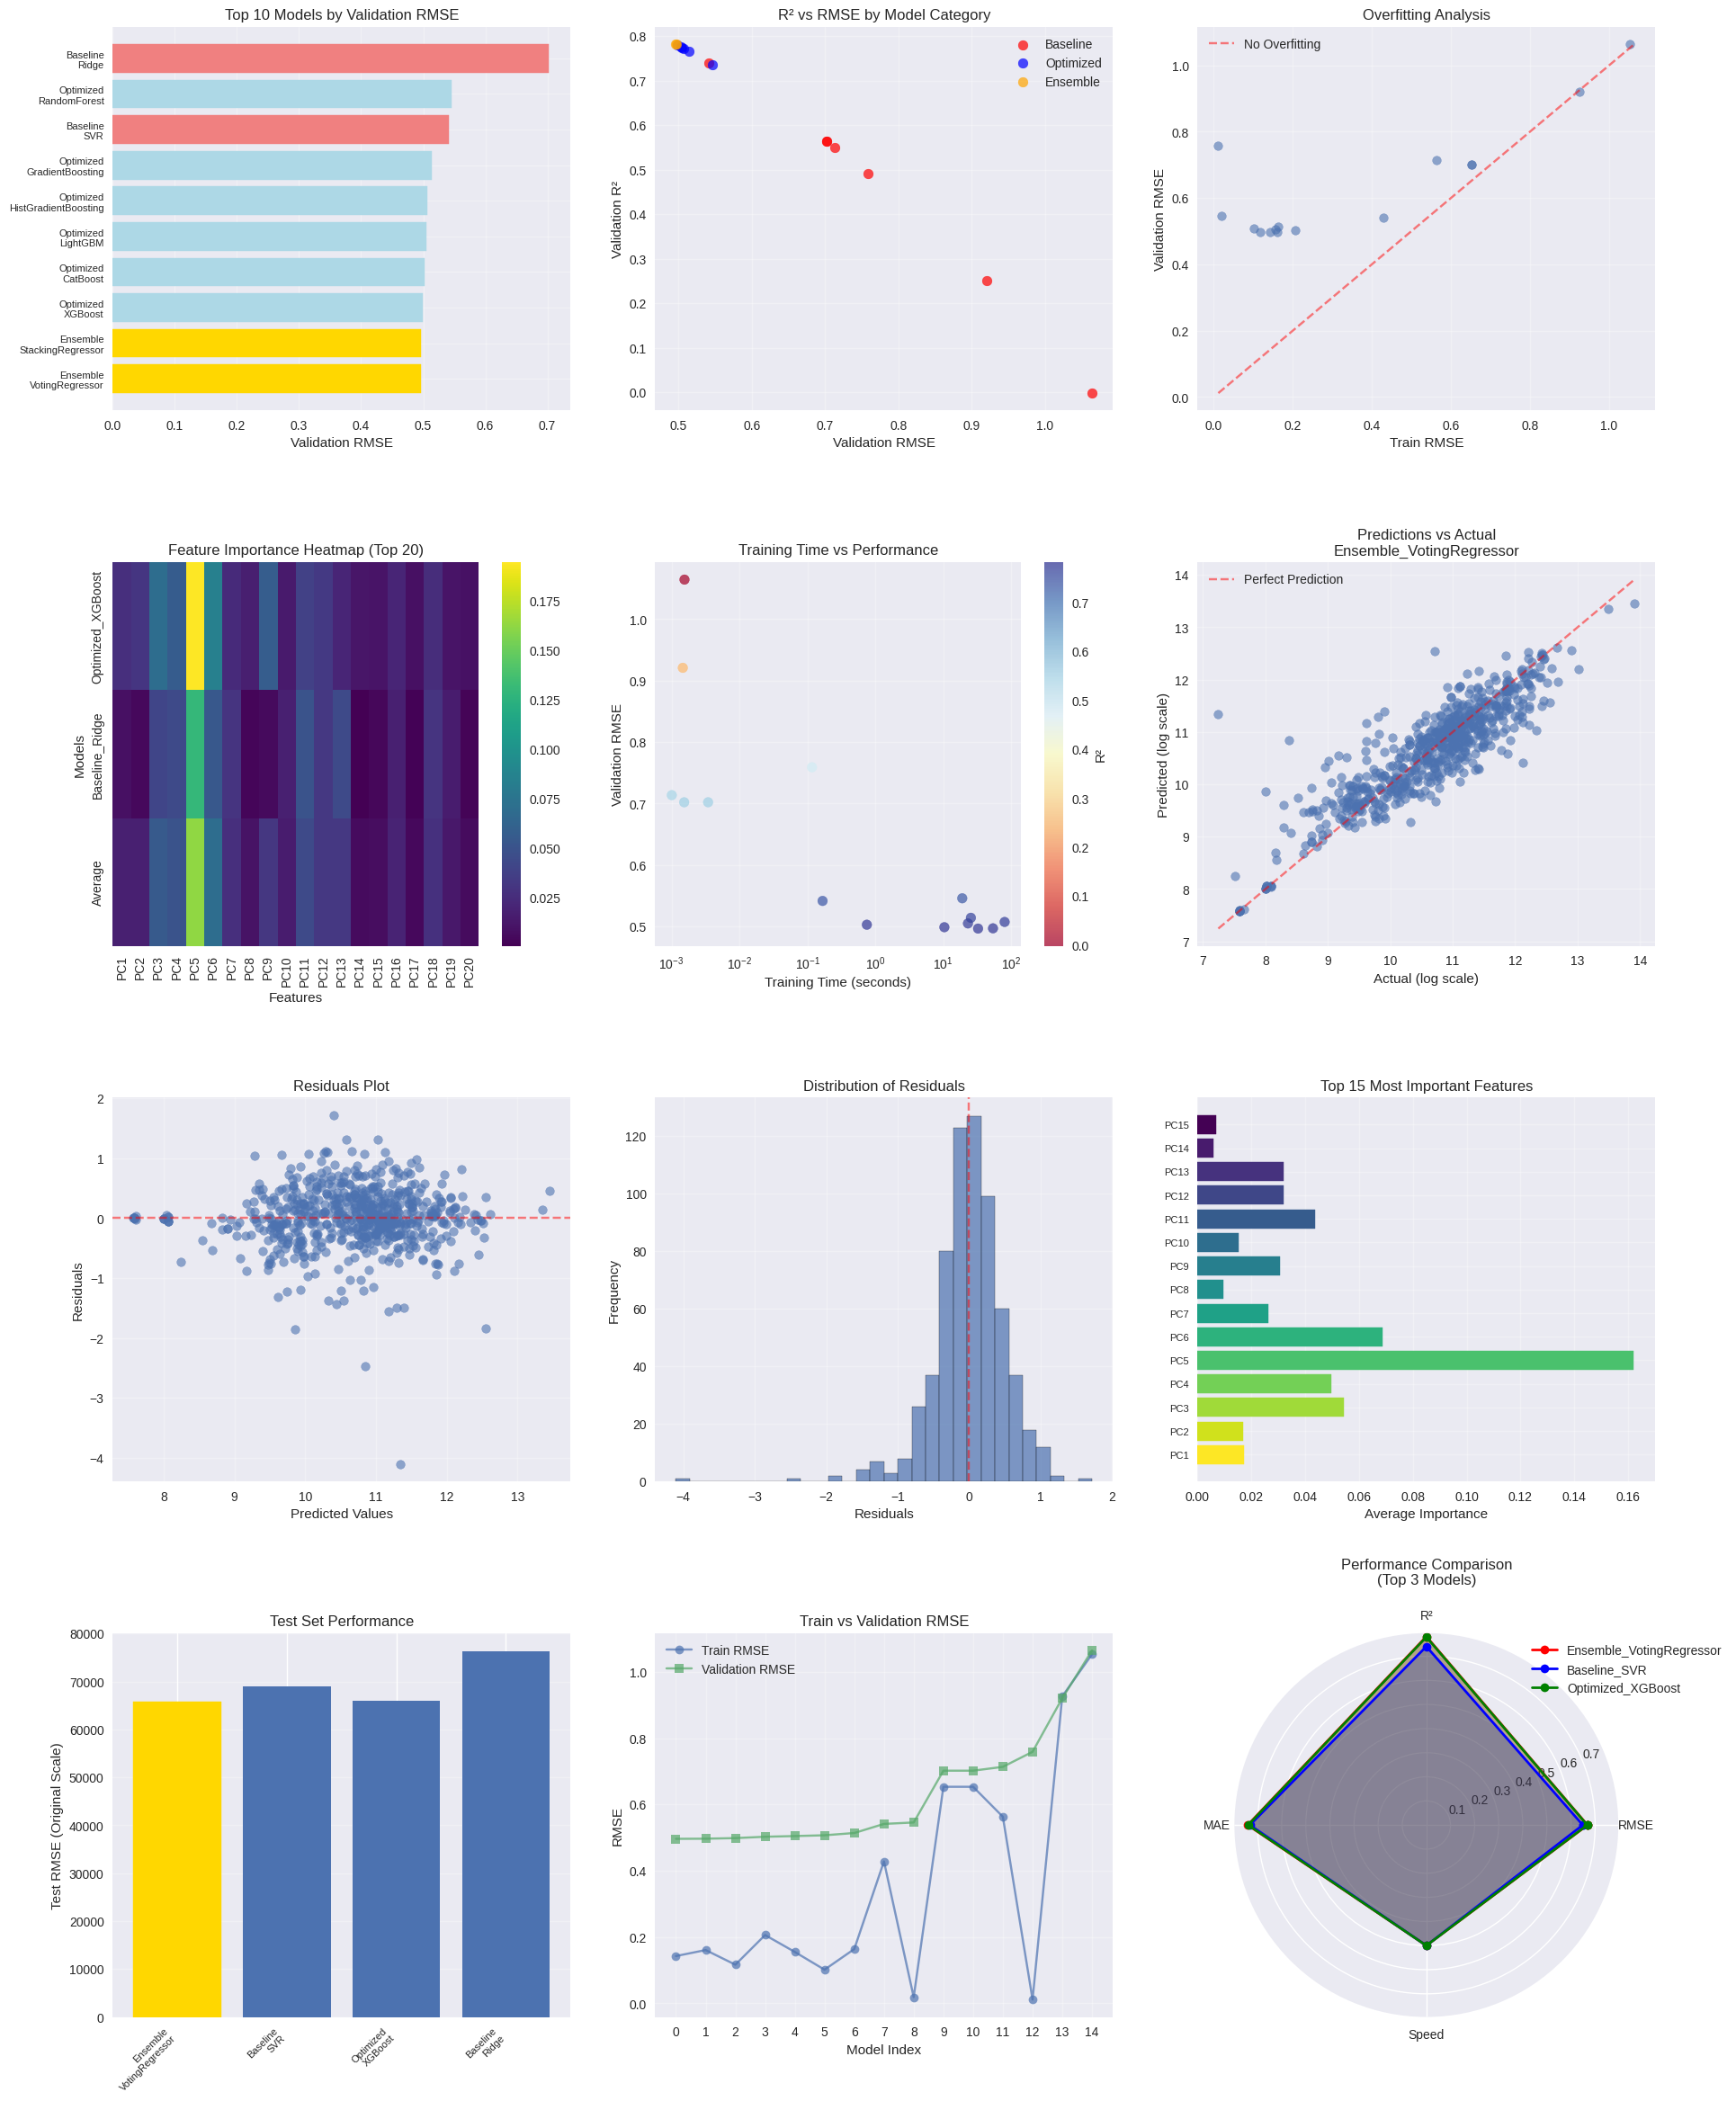

2025-06-27 18:52:32,290 - INFO - Grafici di analisi completati e salvati


In [13]:
# Cella 12: Grafici di analisi

def create_analysis_plots():
    """Crea grafici per l'analisi dei risultati"""
    logger.info("=" * 60)
    logger.info("CREAZIONE GRAFICI DI ANALISI")
    logger.info("=" * 60)
    
    # Setup per i grafici
    plt.style.use('seaborn-v0_8')
    fig = plt.figure(figsize=(20, 24))
    
    # 1. Confronto performance modelli
    ax1 = plt.subplot(4, 3, 1)
    if not df_validation_results.empty:
        top_models = df_validation_results.head(10)
        bars = ax1.barh(range(len(top_models)), top_models['Val_RMSE'])
        ax1.set_yticks(range(len(top_models)))
        ax1.set_yticklabels([name.replace('_', '\n') for name in top_models['Model']], fontsize=8)
        ax1.set_xlabel('Validation RMSE')
        ax1.set_title('Top 10 Models by Validation RMSE')
        ax1.grid(True, alpha=0.3)
        
        # Colora diverse categorie
        colors = []
        for model in top_models['Model']:
            if 'Baseline' in model:
                colors.append('lightcoral')
            elif 'Ensemble' in model:
                colors.append('gold')
            else:
                colors.append('lightblue')
        
        for bar, color in zip(bars, colors):
            bar.set_color(color)
    
    # 2. R² vs RMSE scatter
    ax2 = plt.subplot(4, 3, 2)
    if not df_validation_results.empty:
        colors_map = {'Baseline': 'red', 'Optimized': 'blue', 'Ensemble': 'orange'}
        for category, color in colors_map.items():
            mask = df_validation_results['Model'].str.contains(category)
            if mask.any():
                ax2.scatter(df_validation_results[mask]['Val_RMSE'], 
                           df_validation_results[mask]['Val_R2'],
                           c=color, label=category, alpha=0.7, s=60)
        
        ax2.set_xlabel('Validation RMSE')
        ax2.set_ylabel('Validation R²')
        ax2.set_title('R² vs RMSE by Model Category')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # 3. Overfitting analysis
    ax3 = plt.subplot(4, 3, 3)
    if not df_validation_results.empty:
        ax3.scatter(df_validation_results['Train_RMSE'], df_validation_results['Val_RMSE'], alpha=0.6)
        
        # Linea di riferimento (no overfitting)
        min_rmse = min(df_validation_results['Train_RMSE'].min(), df_validation_results['Val_RMSE'].min())
        max_rmse = max(df_validation_results['Train_RMSE'].max(), df_validation_results['Val_RMSE'].max())
        ax3.plot([min_rmse, max_rmse], [min_rmse, max_rmse], 'r--', alpha=0.5, label='No Overfitting')
        
        ax3.set_xlabel('Train RMSE')
        ax3.set_ylabel('Validation RMSE')
        ax3.set_title('Overfitting Analysis')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # 4. Feature importance heatmap
    ax4 = plt.subplot(4, 3, 4)
    if not feature_importance_summary.empty:
        # Top 20 features
        top_features = feature_importance_summary.iloc[:20]
        if len(top_features.columns) > 1:
            sns.heatmap(top_features.T, annot=False, cmap='viridis', ax=ax4)
            ax4.set_title('Feature Importance Heatmap (Top 20)')
            ax4.set_xlabel('Features')
            ax4.set_ylabel('Models')
    
    # 5. Training time vs Performance
    ax5 = plt.subplot(4, 3, 5)
    if not df_validation_results.empty:
        scatter = ax5.scatter(df_validation_results['Training_Time'], df_validation_results['Val_RMSE'],
                             c=df_validation_results['Val_R2'], cmap='RdYlBu', alpha=0.7, s=60)
        ax5.set_xlabel('Training Time (seconds)')
        ax5.set_ylabel('Validation RMSE')
        ax5.set_title('Training Time vs Performance')
        ax5.set_xscale('log')
        plt.colorbar(scatter, ax=ax5, label='R²')
        ax5.grid(True, alpha=0.3)
    
    # 6. Predictions vs Actual (miglior modello)
    ax6 = plt.subplot(4, 3, 6)
    if best_models and 'best_overall' in best_models:
        best_model_results = best_models['best_overall']['results']
        if 'predictions_val' in best_model_results:
            ax6.scatter(y_val_log, best_model_results['predictions_val'], alpha=0.6)
            
            # Linea di riferimento perfetta
            min_val = min(y_val_log.min(), best_model_results['predictions_val'].min())
            max_val = max(y_val_log.max(), best_model_results['predictions_val'].max())
            ax6.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Perfect Prediction')
            
            ax6.set_xlabel('Actual (log scale)')
            ax6.set_ylabel('Predicted (log scale)')
            ax6.set_title(f'Predictions vs Actual\n{best_models["best_overall"]["name"]}')
            ax6.legend()
            ax6.grid(True, alpha=0.3)
    
    # 7. Residuals plot
    ax7 = plt.subplot(4, 3, 7)
    if best_models and 'best_overall' in best_models:
        best_model_results = best_models['best_overall']['results']
        if 'predictions_val' in best_model_results:
            residuals = y_val_log - best_model_results['predictions_val']
            ax7.scatter(best_model_results['predictions_val'], residuals, alpha=0.6)
            ax7.axhline(y=0, color='r', linestyle='--', alpha=0.5)
            ax7.set_xlabel('Predicted Values')
            ax7.set_ylabel('Residuals')
            ax7.set_title('Residuals Plot')
            ax7.grid(True, alpha=0.3)
    
    # 8. Distribution of residuals
    ax8 = plt.subplot(4, 3, 8)
    if best_models and 'best_overall' in best_models:
        best_model_results = best_models['best_overall']['results']
        if 'predictions_val' in best_model_results:
            residuals = y_val_log - best_model_results['predictions_val']
            ax8.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
            ax8.axvline(x=0, color='r', linestyle='--', alpha=0.5)
            ax8.set_xlabel('Residuals')
            ax8.set_ylabel('Frequency')
            ax8.set_title('Distribution of Residuals')
            ax8.grid(True, alpha=0.3)
    
    # 9. Feature importance bar plot
    ax9 = plt.subplot(4, 3, 9)
    if not df_feature_importance.empty and 'Average' in feature_importance_summary.columns:
        top_features = feature_importance_summary['Average'].head(15)
        bars = ax9.barh(range(len(top_features)), top_features.values)
        ax9.set_yticks(range(len(top_features)))
        ax9.set_yticklabels(top_features.index, fontsize=8)
        ax9.set_xlabel('Average Importance')
        ax9.set_title('Top 15 Most Important Features')
        ax9.grid(True, alpha=0.3)
        
        # Gradient color
        colors = plt.cm.viridis_r(np.linspace(0, 1, len(bars)))
        for bar, color in zip(bars, colors):
            bar.set_color(color)
    
    # 10. Test set performance comparison
    ax10 = plt.subplot(4, 3, 10)
    if test_results:
        valid_test_results = {k: v for k, v in test_results.items() if 'error' not in v}
        if valid_test_results:
            model_names = [v['model_name'] for v in valid_test_results.values()]
            rmse_values = [v['rmse_orig'] for v in valid_test_results.values()]
            
            bars = ax10.bar(range(len(model_names)), rmse_values)
            ax10.set_xticks(range(len(model_names)))
            ax10.set_xticklabels([name.replace('_', '\n') for name in model_names], 
                                rotation=45, ha='right', fontsize=8)
            ax10.set_ylabel('Test RMSE (Original Scale)')
            ax10.set_title('Test Set Performance')
            ax10.grid(True, axis='y', alpha=0.3)
            
            # Colora la barra del miglior modello
            best_idx = np.argmin(rmse_values)
            bars[best_idx].set_color('gold')
    
    # 11. Learning curves simulation (validation vs train error)
    ax11 = plt.subplot(4, 3, 11)
    if not df_validation_results.empty:
        train_rmse = df_validation_results['Train_RMSE']
        val_rmse = df_validation_results['Val_RMSE']
        model_names = df_validation_results['Model']
        
        x = range(len(model_names))
        ax11.plot(x, train_rmse, 'o-', label='Train RMSE', alpha=0.7)
        ax11.plot(x, val_rmse, 's-', label='Validation RMSE', alpha=0.7)
        ax11.set_xlabel('Model Index')
        ax11.set_ylabel('RMSE')
        ax11.set_title('Train vs Validation RMSE')
        ax11.legend()
        ax11.grid(True, alpha=0.3)
        
        # Ruota le etichette se ci sono troppi modelli
        if len(model_names) > 5:
            ax11.set_xticks(x[::max(1, len(x)//10)])  # Mostra solo alcune etichette
    
    # 12. Performance metrics comparison radar chart
    ax12 = plt.subplot(4, 3, 12, projection='polar')
    if best_models and len(best_models) > 1:
        try:
            # Seleziona i top 3 modelli per il radar chart
            top_3_models = list(best_models.keys())[:3]
            metrics = ['RMSE', 'R²', 'MAE', 'Speed']
            
            angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
            angles += angles[:1]  # Chiude il cerchio
            
            colors = ['red', 'blue', 'green']
            
            for i, model_key in enumerate(top_3_models):
                if 'results' in best_models[model_key]:
                    results = best_models[model_key]['results']
                    
                    # Normalizza le metriche (invertendo RMSE e MAE per la visualizzazione)
                    values = [
                        1 / (1 + results.get('val_rmse', 1)),  # RMSE invertito
                        results.get('val_r2', 0),  # R²
                        1 / (1 + results.get('val_mae', 1)),  # MAE invertito
                        1 / (1 + best_models[model_key].get('training_time', 1))  # Speed (tempo invertito)
                    ]
                    values += values[:1]  # Chiude il cerchio
                    
                    ax12.plot(angles, values, 'o-', linewidth=2, 
                             label=best_models[model_key]['name'], color=colors[i])
                    ax12.fill(angles, values, alpha=0.25, color=colors[i])
            
            ax12.set_xticks(angles[:-1])
            ax12.set_xticklabels(metrics)
            ax12.set_title('Performance Comparison\n(Top 3 Models)', pad=20)
            ax12.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
            
        except Exception as e:
            # Fallback: semplice grafico a barre se il radar chart fallisce
            ax12.remove()
            ax12 = plt.subplot(4, 3, 12)
            ax12.text(0.5, 0.5, f'Radar chart error:\n{str(e)[:50]}...', 
                     ha='center', va='center', transform=ax12.transAxes)
            ax12.set_title('Performance Comparison')
    
    # Regola il layout
    plt.tight_layout(pad=3.0)
    
    # Salva il grafico
    plt.savefig(f'results/{TRAINING_TIMESTAMP}/plots.png', dpi=300, bbox_inches='tight')
    
    # Mostra il grafico
    plt.show()
    
    logger.info("Grafici di analisi completati e salvati")


# Esegui l'analisi completa
create_analysis_plots()

In [14]:
# Cella 13: Generazione del summary dell'analisi

def generate_analysis_summary():
    """Genera un summary testuale dell'analisi"""
    logger.info("\n" + "=" * 60)
    logger.info("SUMMARY DELL'ANALISI")
    logger.info("=" * 60)

    try:
        # Best model overall
        if best_models and 'best_overall' in best_models:
            best_model = best_models['best_overall']
            results = best_model.get('results', {})
            
            logger.info(f"\n🏆 MIGLIOR MODELLO OVERALL:")
            logger.info(f"   Nome: {best_model.get('name', 'N/A')}")
            logger.info(f"   Validation RMSE: {results.get('val_rmse', float('nan')):.4f}")
            logger.info(f"   Validation R²: {results.get('val_r2', float('nan')):.4f}")
            
            training_time = results.get('training_time', None)
            if isinstance(training_time, (int, float)):
                logger.info(f"   Training Time: {training_time:.2f}s")
            else:
                logger.info("   Training Time: N/A")
        
        # Performance statistics
        if not df_validation_results.empty:
            logger.info(f"\n📊 STATISTICHE PERFORMANCE:")
            logger.info(f"   Numero totale modelli: {len(df_validation_results)}")
            logger.info(f"   RMSE medio: {df_validation_results['Val_RMSE'].mean():.4f}")
            logger.info(f"   RMSE std: {df_validation_results['Val_RMSE'].std():.4f}")
            logger.info(f"   R² medio: {df_validation_results['Val_R2'].mean():.4f}")
            logger.info(f"   Tempo training medio: {df_validation_results['Training_Time'].mean():.2f}s")
        
        # Feature importance insights
        if not feature_importance_summary.empty and 'Average' in feature_importance_summary.columns:
            top_5_features = feature_importance_summary['Average'].sort_values(ascending=False).head(5)
            logger.info(f"\n🔍 TOP 5 FEATURE PIÙ IMPORTANTI:")
            for i, (feature, importance) in enumerate(top_5_features.items(), 1):
                logger.info(f"   {i}. {feature}: {importance:.4f}")
        
        # Test results summary
        if test_results:
            valid_test_results = {k: v for k, v in test_results.items() if 'error' not in v}
            if valid_test_results:
                logger.info(f"\n🎯 PERFORMANCE SU TEST SET:")
                for model_key, results in valid_test_results.items():
                    logger.info(f"   {results['model_name']}: RMSE = {results['rmse_orig']:.4f}")
        
        # Overfitting analysis
        if not df_validation_results.empty:
            overfitting_ratio = (df_validation_results['Val_RMSE'] / df_validation_results['Train_RMSE']).mean()
            logger.info(f"\n⚠️  ANALISI OVERFITTING:")
            logger.info(f"   Ratio Val/Train RMSE medio: {overfitting_ratio:.3f}")
            if overfitting_ratio > 1.2:
                logger.info("   ⚠️  Possibile overfitting detectato!")
            elif overfitting_ratio < 1.05:
                logger.info("   ⚠️  Possibile underfitting detectato!")
            else:
                logger.info("   ✅ Buon bilanciamento bias-variance!")
    
    except Exception as e:
        logger.error(f"Errore nella generazione del summary: {e}")
    
    logger.info("=" * 60)

# Genera il summary dell'analisi
generate_analysis_summary()

2025-06-27 18:52:32,301 - INFO - 
2025-06-27 18:52:32,301 - INFO - SUMMARY DELL'ANALISI
2025-06-27 18:52:32,302 - INFO - ============================================================
2025-06-27 18:52:32,302 - INFO - 
🏆 MIGLIOR MODELLO OVERALL:
2025-06-27 18:52:32,302 - INFO -    Nome: Ensemble_VotingRegressor
2025-06-27 18:52:32,303 - INFO -    Validation RMSE: 0.4964
2025-06-27 18:52:32,303 - INFO -    Validation R²: 0.7820
2025-06-27 18:52:32,303 - INFO -    Training Time: 32.56s
2025-06-27 18:52:32,303 - INFO - 
📊 STATISTICHE PERFORMANCE:
2025-06-27 18:52:32,303 - INFO -    Numero totale modelli: 15
2025-06-27 18:52:32,304 - INFO -    RMSE medio: 0.6313
2025-06-27 18:52:32,304 - INFO -    RMSE std: 0.1763
2025-06-27 18:52:32,305 - INFO -    R² medio: 0.6218
2025-06-27 18:52:32,305 - INFO -    Tempo training medio: 16.38s
2025-06-27 18:52:32,305 - INFO - 
🔍 TOP 5 FEATURE PIÙ IMPORTANTI:
2025-06-27 18:52:32,306 - INFO -    1. PC5: 0.1619
2025-06-27 18:52:32,306 - INFO -    2. PC6: 0.06